# Ungraded Lab: Knowledge Distillation
------------------------
 
Welcome, during this ungraded lab you are going to perform a model compression technique known as **knowledge distillation** in which a `student` model "learns" from a more complex model known as the `teacher`. In particular you will:


1. Define a `Distiller` class with the custom logic for the distillation process.
2. Train the `teacher` model which is a CNN that implements regularization via dropout.
3. Train a `student` model (a smaller version of the teacher without regularization) by using knowledge distillation.
4. Train another `student` model from scratch without distillation called `student_scratch`.
5. Compare the three students.


This notebook is based on [this](https://keras.io/examples/vision/knowledge_distillation/) official Keras tutorial. 

If you want a more theoretical approach to this topic be sure to check this paper [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531). 

Let's get started!


## Imports

In [1]:
# NOTE (05/16/2022) - The default URL for downloading the dataset via TFDS is currently invalid. This piece of code
# will patch that URL with the correct one. Please run this before importing the packages. If it fails, kindly report
# in our Discourse community. Thank you!

DATASET_PATH = '/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py'
!sed -i 's/3367a/5340/g' {DATASET_PATH}

In [2]:
# For setting random seeds
import os
os.environ['PYTHONHASHSEED']=str(42)

# Libraries
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# More random seed setup
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Prepare the data

For this lab you will use the [cats vs dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) which is composed of many images of cats and dogs alongise their respective labels. 

Begin by downloading the data:

In [3]:
# Define train/test splits
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# Download the dataset
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

# Print useful information
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print(f"There are {num_examples} images for {num_classes} classes.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHBRPOI/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
There are 23262 images for 2 classes.


Preprocess the data for training by normalizing pixel values, reshaping them and creating batches of data:

In [4]:
# Some global variables
pixels = 224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

# Apply resizing and pixel normalization
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

# Create batches of data
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

## Code the custom `Distiller` model

In order to implement the distillation process you will create a custom Keras model which you will name `Distiller`. In order to do this you need to override some of the vanilla methods of a `keras.Model` to include the custom logic for the knowledge distillation. You need to override these methods:
- `compile`: This model needs some extra parameters to be compiled such as the teacher and student losses, the alpha and the temperature.
- `train_step`: Controls how the model is trained. This will be where the actual knowledge distillation logic will be found. This method is what is called when you do `model.fit`.
- `test_step`: Controls the evaluation of the model. This method is what is called when you do `model.evaluate`.

To learn more about customizing models check out the [official docs](https://keras.io/guides/customizing_what_happens_in_fit/).

In [5]:
class Distiller(keras.Model):

  # Needs both the student and teacher models to create an instance of this class
  def __init__(self, student, teacher):
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student


  # Will be used when calling model.compile()
  def compile(self, optimizer, metrics, student_loss_fn,
              distillation_loss_fn, alpha, temperature):

      # Compile using the optimizer and metrics
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      
      # Add the other params to the instance
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature


  # Will be used when calling model.fit()
  def train_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Vanilla forward pass of the teacher
      # Note that the teacher is NOT trained
      teacher_predictions = self.teacher(x, training=False)

      # Use GradientTape to save gradients
      with tf.GradientTape() as tape:
          # Vanilla forward pass of the student
          student_predictions = self.student(x, training=True)

          # Compute vanilla student loss
          student_loss = self.student_loss_fn(y, student_predictions)
          
          # Compute distillation loss
          # Should be KL divergence between logits softened by a temperature factor
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
              tf.nn.softmax(student_predictions / self.temperature, axis=1))

          # Compute loss by weighting the two previous losses using the alpha param
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Use tape to calculate gradients for student
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update student weights 
      # Note that this done ONLY for the student
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a performance dictionary
      # You will see this being outputted during training
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
      return results


  # Will be used when calling model.evaluate()
  def test_step(self, data):
      # Data is expected to be a tuple of (features, labels)
      x, y = data

      # Use student to make predictions
      # Notice that the training param is set to False
      y_prediction = self.student(x, training=False)

      # Calculate student's vanilla loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a performance dictionary
      # You will see this being outputted during inference
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results


## Teacher and student models

For the models you will use a standard CNN architecture that implements regularization via some dropout layers (in the case of the teacher), but it could be any Keras model. 

Define the `create_model` functions to create models with the desired architecture using Keras' [Sequential Model](https://keras.io/guides/sequential_model/).

Notice that `create_small_model` returns a simplified version of the model (in terms of number of layers and absence of regularization) that `create_big_model` returns:

In [6]:
# Teacher model
def create_big_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(2)
  ])

  return model



# Student model
def create_small_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2)
  ])

  return model

There are two important things to notice:
- The last layer does not have an softmax activation because the raw logits are needed for the knowledge distillation.
- Regularization via dropout layers will be applied to the teacher but NOT to the student. This is because the student should be able to learn this regularization through the distillation process.

Remember that the student model can be thought of as a simplified (or compressed) version of the teacher model.



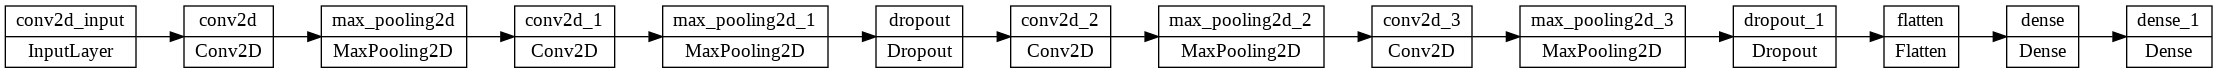

In [7]:
# Create the teacher
teacher = create_big_model()

# Plot architecture
keras.utils.plot_model(teacher, rankdir="LR")

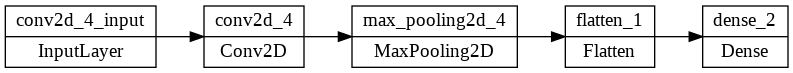

In [8]:
# Create the student
student = create_small_model()

# Plot architecture
keras.utils.plot_model(student, rankdir="LR")

Check the actual difference in number of trainable parameters (weights and biases) between both models:

In [9]:
# Calculates number of trainable params for a given model
def num_trainable_params(model):
  return np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])


student_params = num_trainable_params(student)
teacher_params = num_trainable_params(teacher)

print(f"Teacher model has: {teacher_params} trainable params.\n")
print(f"Student model has: {student_params} trainable params.\n")
print(f"Teacher model is roughly {teacher_params//student_params} times bigger than the student model.")

Teacher model has: 9568898 trainable params.

Student model has: 789442 trainable params.

Teacher model is roughly 12 times bigger than the student model.


### Train the teacher

In knowledge distillation it is assumed that the teacher has already been trained so the natural first step is to train the teacher. You will do so for a total of 8 epochs:

In [10]:
# Compile the teacher model
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Notice from_logits param is set to True
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model and save the training history (will take from 5 to 10 minutes depending on the GPU you were assigned to)
teacher_history = teacher.fit(train_batches, epochs=8, validation_data=validation_batches)

Epoch 1/8
582/582 [==============================] - 55s 66ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.5909 - val_loss: 0.5874 - val_sparse_categorical_accuracy: 0.6840
Epoch 2/8
582/582 [==============================] - 40s 62ms/step - loss: 0.5736 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.5128 - val_sparse_categorical_accuracy: 0.7575
Epoch 3/8
582/582 [==============================] - 40s 62ms/step - loss: 0.4998 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.4401 - val_sparse_categorical_accuracy: 0.8078
Epoch 4/8
582/582 [==============================] - 40s 62ms/step - loss: 0.4449 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.4119 - val_sparse_categorical_accuracy: 0.8237
Epoch 5/8
582/582 [==============================] - 40s 62ms/step - loss: 0.3959 - sparse_categorical_accuracy: 0.8204 - val_loss: 0.3752 - val_sparse_categorical_accuracy: 0.8306
Epoch 6/8
582/582 [==============================] - 39s 61ms/step - loss: 0.3471 - sparse_cate

## Train a student from scratch for reference

In order to assess the effectiveness of the distillation process, train a model that is equivalent to the student but without doing knowledge distillation. Notice that the training is done for only 5 epochs:

In [11]:
# Create student_scratch model with the same characteristics as the original student
student_scratch = create_small_model()

# Compile it
student_scratch.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train and evaluate student trained from scratch (will take around 3 mins with GPU enabled)
student_scratch_history = student_scratch.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 31s 46ms/step - loss: 0.7745 - sparse_categorical_accuracy: 0.6564 - val_loss: 0.5972 - val_sparse_categorical_accuracy: 0.6939
Epoch 2/5
582/582 [==============================] - 31s 46ms/step - loss: 0.4897 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.6252 - val_sparse_categorical_accuracy: 0.7055
Epoch 3/5
582/582 [==============================] - 31s 46ms/step - loss: 0.3772 - sparse_categorical_accuracy: 0.8307 - val_loss: 0.6567 - val_sparse_categorical_accuracy: 0.7081
Epoch 4/5
582/582 [==============================] - 31s 46ms/step - loss: 0.2737 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.7256 - val_sparse_categorical_accuracy: 0.7150
Epoch 5/5
582/582 [==============================] - 31s 46ms/step - loss: 0.1905 - sparse_categorical_accuracy: 0.9316 - val_loss: 0.8423 - val_sparse_categorical_accuracy: 0.7141


## Knowledge Distillation

To perform the knowledge distillation process you will use the custom model you previously coded. To do so, begin by creating an instance of the `Distiller` class and passing in the student and teacher models. Then compile it with the appropiate parameters and train it!

The two student models are trained for only 5 epochs unlike the teacher that was trained for 8. This is done to showcase that the knowledge distillation allows for quicker training times as the student learns from an already trained model.

In [12]:
# Create Distiller instance
distiller = Distiller(student=student, teacher=teacher)

# Compile Distiller model
distiller.compile(
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=5,
)

# Distill knowledge from teacher to student (will take around 3 mins with GPU enabled)
distiller_history = distiller.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 35s 52ms/step - sparse_categorical_accuracy: 0.6317 - student_loss: 0.8465 - distillation_loss: 0.1014 - val_sparse_categorical_accuracy: 0.6268 - val_student_loss: 0.9061
Epoch 2/5
582/582 [==============================] - 34s 52ms/step - sparse_categorical_accuracy: 0.7200 - student_loss: 0.5794 - distillation_loss: 0.0572 - val_sparse_categorical_accuracy: 0.7068 - val_student_loss: 0.7052
Epoch 3/5
582/582 [==============================] - 35s 53ms/step - sparse_categorical_accuracy: 0.7793 - student_loss: 0.4772 - distillation_loss: 0.0443 - val_sparse_categorical_accuracy: 0.7425 - val_student_loss: 0.5570
Epoch 4/5
582/582 [==============================] - 35s 53ms/step - sparse_categorical_accuracy: 0.8242 - student_loss: 0.3867 - distillation_loss: 0.0352 - val_sparse_categorical_accuracy: 0.7081 - val_student_loss: 0.6730
Epoch 5/5
582/582 [==============================] - 34s 52ms/step - sparse_categorical_accuracy: 0.

## Comparing the models

To compare the models you can check the `sparse_categorical_accuracy` of each one on the test set:

In [13]:
# Compute accuracies
student_scratch_acc = student_scratch.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
distiller_acc = distiller.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
teacher_acc = teacher.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")

# Print results
print(f"\n\nTeacher achieved a sparse_categorical_accuracy of {teacher_acc*100:.2f}%.\n")
print(f"Student with knowledge distillation achieved a sparse_categorical_accuracy of {distiller_acc*100:.2f}%.\n")
print(f"Student without knowledge distillation achieved a sparse_categorical_accuracy of {student_scratch_acc*100:.2f}%.\n")

2326/2326 [==============================] - 9s 4ms/step - loss: 0.3188 - sparse_categorical_accuracy: 0.8633


Teacher achieved a sparse_categorical_accuracy of 86.33%.

Student with knowledge distillation achieved a sparse_categorical_accuracy of 74.55%.

Student without knowledge distillation achieved a sparse_categorical_accuracy of 71.28%.



The teacher model yields a higger accuracy than the two student models. This is expected since it was trained for more epochs while using a bigger architecture.

Notice that the student without distillation was outperfomed by the student with knowledge distillation. 

Since you saved the training history of each model you can create a plot for a better comparison of the two student models.

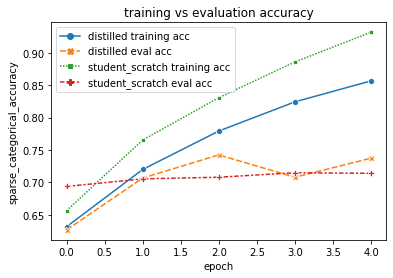

In [14]:
# Get relevant metrics from a history
def get_metrics(history):
  history = history.history
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']
  return acc, val_acc


# Plot training and evaluation metrics given a dict of histories
def plot_train_eval(history_dict):
  
  metric_dict = {}

  for k, v in history_dict.items():
    acc, val_acc= get_metrics(v)
    metric_dict[f'{k} training acc'] = acc
    metric_dict[f'{k} eval acc'] = val_acc

  acc_plot = pd.DataFrame(metric_dict)
  
  acc_plot = sns.lineplot(data=acc_plot, markers=True)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()


# Plot for comparing the two student models
plot_train_eval({
    "distilled": distiller_history,
    "student_scratch": student_scratch_history,
})

This plot is very interesting because it shows that the distilled version outperformed the unmodified one in almost all of the epochs when using the evaluation set. Alongside this, the student without distillation yields a bigger training accuracy, which is a sign that it is overfitting more than the distilled model. **This hints that the distilled model was able to learn from the regularization that the teacher implemented!** Pretty cool, right?

-----------------------------
**Congratulations on finishing this ungraded lab!** Now you should have a clearer understanding of what Knowledge Distillation is and how it can be implemented using Tensorflow and Keras. 

This process is widely used for model compression and has proven to perform really well. In fact you might have heard about [`DistilBert`](https://huggingface.co/transformers/model_doc/distilbert.html), which is a smaller, faster, cheaper and lighter of BERT.


**Keep it up!**